# **Uso de Transfer Learning para Classificação de Imagens do Dataset MSCOCO**

#### **Professores:** Roberto A. Lotufo e Rodrigo F. Nogueira
#### **Aluno:** Guilherme Rosa

### **1. Imports**

In [ ]:
! pip install efficientnet_pytorch

In [ ]:
import h5py
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter, OrderedDict
from efficientnet_pytorch import EfficientNet
from torchvision import transforms

In [ ]:
!nvidia-smi

Fri Oct 23 20:48:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

Usando: cuda


### **2. Preparação dos dados**

#### **2.1. Download das amostras de treinamento, validação e teste**

In [ ]:
#Download

Skipping existing item: file://./TEST_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5
Skipping existing item: file://./VAL_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5
Skipping existing item: file://./TRAIN_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5
Skipping existing item: file://./TEST_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json
Skipping existing item: file://./VAL_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json
Skipping existing item: file://./TRAIN_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json
Skipping existing item: file://./WORDMAP_coco_5_cap_per_img_5_min_word_freq.json


#### **2.2. Implementação da subclasse da classe Dataset**


Pipeline de transformações na imagem de entrada:

- Etapa 1: Mudança no shape para converter numpy arrays em PIL images.
  - Imagem no formato numpy array: (C, H, W) = (3, 256, 256)
  - Imagem no formato PIL image  : (H, W, C) = (256, 256, 3)

- Etapa 2: Mudança de numpy array para PIL image e resize da imagem.
  - Fazemos a mudança de numpy array para PIL image com transforms.ToPILImage() porque o transforms.Resize é aplicado a dados no formato PIL images. .
  - Fazemos a mudança de shape (256, 256, 3) para (224, 224, 3) porque a EfficientNet foi treinada com imagens neste formato. Para isso, utilizamos o transforms.Resize().
  - Por fim, utilizamos o transforms.ToTensor() para converter as imagens de PIL Image para torch tensor, além de normalizar os pixels de modo que estejam entre [0, 1]. 

- Etapa 3: normalização
  - Cada canal é normalizado de modo que tenha um determinado par média-desvio padrão. Para isso, utilizamos o torch.Normalize().
  - A normalização que a EfficientNet utilizou é a seguinte:
           Canal  -  Média  -  Variância
             1       0.485       0.229
             2       0.456       0.224
             3       0.406       0.225 

In [ ]:
class MSCOCODataset(Dataset):
    def __init__(self, images_hdf5_path, captions_json_path, wordmap_json_path, transforms=None):
        """ Cria uma instância da classe torch.utils.data.Dataset customizada para o dataset de imagens do MSCOCO.
            É utilizada pelo torch.utils.data.DataLoader como base para criar os mini-batches de treinamento.  
        """
        super(MSCOCODataset, self).__init__()

        self.images_hdf5_path = images_hdf5_path
        self.captions_json_path = captions_json_path
        self.wordmap_json_path = wordmap_json_path
        self.transforms = transforms

        self.images = self.__getimages()
        self.labels = self.__getlabels()
        self.wordmap = json.load(open(self.wordmap_json_path, 'r'))
        self.wordmap_reverse = {labels: classes for classes, labels in self.wordmap.items()}

    def __len__(self):
        """ Retorna o número de amostras do dataset. """
        return self.images.shape[0]
    
    def __getitem__(self, index):
        """ Permite que a classe possa ser indexada. Retorna uma tupla com o par de tensores (imagem, label) referente ao índice dado. """

        # PIPELINE DE TRANSFORMAÇÕES NA IMAGEM
        # ETAPA 1
        # images.shape = (3, 256, 256) -> (256, 256, 3)
        images = np.transpose(self.images[index], axes=(1, 2, 0)) 

        # ETAPA 2:
        # numpy array -> PIL image || images.shape = (256, 256, 3) -> (224, 224, 3) || 
        # PIL image -> torch.tensor || images.shape = (224, 224, 3) -> (3, 224, 224)
        if self.transforms:                        
            images = self.transforms(images) 

        # É feita uma modificação nas labels para que as classes sejam representadas por variáveis categóricas de 0 a 9, e não de 1 a 10 como está originalmente no dataset.
        # O tipo dos dados foi modificado para torch.uint8 para reduzir o uso de memória.
        labels = torch.tensor(self.labels[index]-1, dtype=torch.long)
        return images, labels
    
    def __getimages(self):
        """ Faz a leitura do arquivo HDF5 com o módulo h5py e retorna o dataset contendo as imagens. """

        images_hdf5file = h5py.File(self.images_hdf5_path, mode='r')
        return images_hdf5file['images']
    
    def __getlabels(self):
        """ Faz a leitura do arquivo json com o módulo json e retorna as labels para cada imagem."""

        captions_jsonfile = json.load(open(self.captions_json_path, 'r'))
        labels = np.array(captions_jsonfile[::5])    # Como existem 5 captions por imagem, a mesma label é repetida 5x. Por essa razão pegamos as labels com passo de 5.
        labels = labels[::, 1]    # Ao verificar o conteúdo de cada lista, vemos que as labels estão armazenadas na segunda posição (índice 1).
        return labels

    def plot_sample_data(self):
        """ Apresenta 10 amostras do conjunto de dados. """

        fig = plt.figure(figsize=(20, 10))
        for i, idx in enumerate(torch.randint(0, self.images.shape[0], size=(10,))):
            fig.add_subplot(2, 5, i+1)
            plt.imshow(np.transpose(self.images[idx], (1, 2, 0)))
            plt.title(f'Classe: {self.wordmap_reverse[self.labels[idx]]}')
            plt.xticks([])
            plt.yticks([])
        del i, idx        
    
    def dataset_info(self):
        """ Apresenta o número de amostras por classe do conjunto de dados. """
        
        self.classes_name = [self.wordmap_reverse[label] for label in self.labels]
        self.num_elements = Counter(self.classes_name)
        for class_name, num_elements in self.num_elements.items():
            print(f'{class_name.title()}: {num_elements}')
        del self.classes_name, class_name, num_elements
  

In [ ]:
from torchvision import transforms
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]) 
                              

train_dataset = MSCOCODataset('/content/TRAIN_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/TRAIN_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                              '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json',
                              transforms=transforms)

valid_dataset = MSCOCODataset('/content/VAL_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/VAL_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                              '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json',
                              transforms=transforms)

test_dataset = MSCOCODataset('/content/TEST_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/TEST_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                             '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json',
                              transforms=transforms)

In [ ]:
print('Número de amostras do conjunto de treinamento:')
train_dataset.dataset_info()
print()
print('Número de amostras do conjunto de validação:')
valid_dataset.dataset_info()
print()
print('Número de amostras do conjunto de teste:')
test_dataset.dataset_info()

Número de amostras do conjunto de treinamento:
Cat: 3124
Truck: 1518
Boat: 1452
Bird: 1043
House: 1243
Car: 2093
Airplane: 2168
Horse: 1890
Tree: 2626
Dog: 3660

Número de amostras do conjunto de validação:
Cat: 162
Car: 109
Airplane: 75
Truck: 62
Tree: 120
Horse: 96
Dog: 161
House: 53
Bird: 43
Boat: 62

Número de amostras do conjunto de teste:
Airplane: 87
Truck: 80
Dog: 152
House: 65
Boat: 73
Tree: 105
Bird: 47
Cat: 147
Horse: 78
Car: 98


#### **2.3. Exemplos de amostras do dataset MSCOCO**

Exemplos de amostras de treinamento:

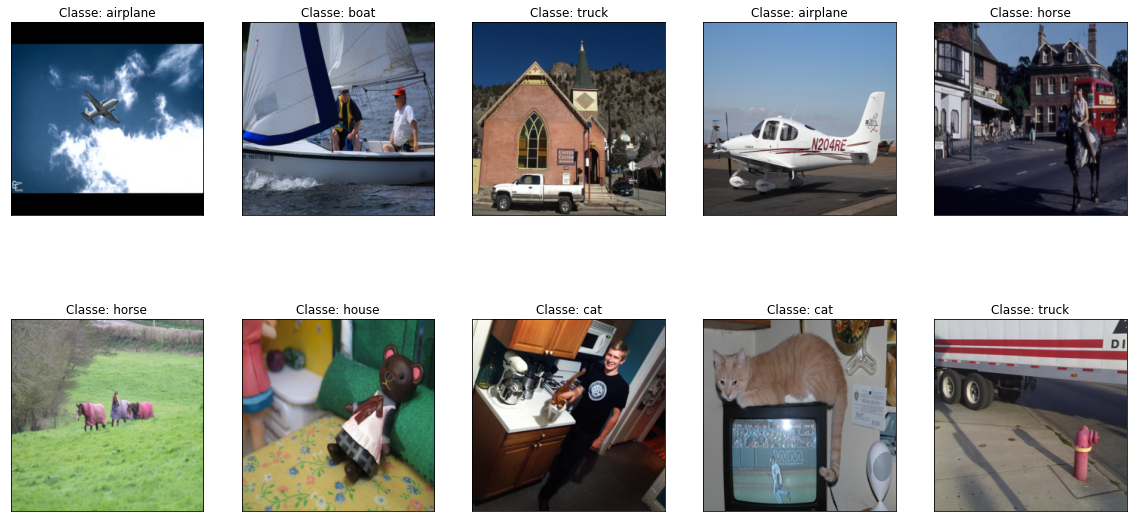

In [ ]:
train_dataset.plot_sample_data()

Exemplos de amostras de validação:

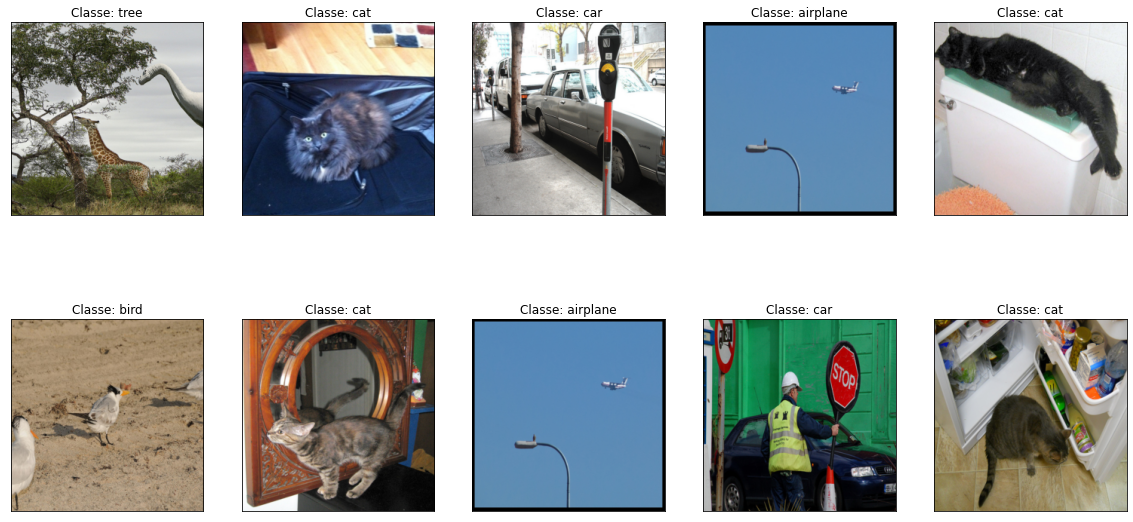

In [ ]:
valid_dataset.plot_sample_data()

Exemplos de amostras de teste:

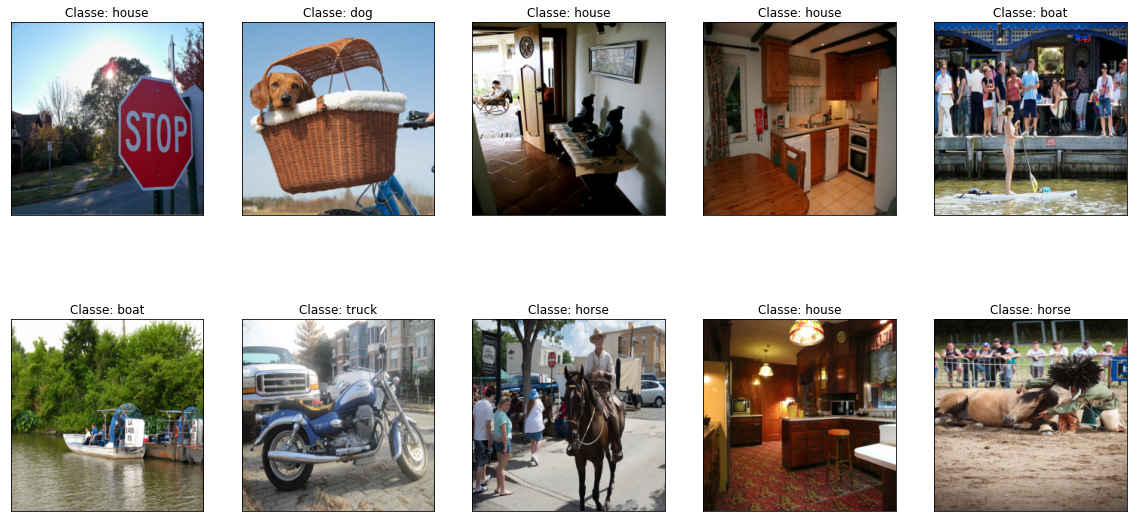

In [ ]:
test_dataset.plot_sample_data()

### **3. Funções auxiliares**

#### **3.1. Função para cálculo da acurácia (taxa de acerto):**

In [ ]:
def accuracy_metric(logits, labels):
    probs = F.softmax(logits, dim=1)                         # Retorna as probabilidades de saída para cada amostra do mini-batch
    top_prob, top_class = probs.topk(1, dim=1)               # Método topk() retorna o(s) k maior(es) valor(es) e seu(s) índice(s)
    equals = top_class == labels.view(*top_class.shape)      # Retorna tensor booleano com True para as amostras classificadas corretamente.
    batch_score = torch.sum(equals.type(torch.FloatTensor))  # Soma o número de acertos no mini-batch
    
    return batch_score

#### **3.2. Função para plotar os gráficos do custo e da acurácia:**

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, num):
    plt.figure(num)
    plt.plot(train_metric, label='Training '+ metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.title(metric_name.title() + ' vs Epochs')
    plt.legend(frameon=False)

    return

#### **3.3. Função de treinamento:**

- O decorador @torch.enable_grad() permite que o gradiente seja calculado para os parâmetros do modelo.

- O método model.train() é necessário para ativar o Dropout durante o treinamento, isto é, que a cada mini-batch apresentado um conjunto aleatório de neurônios seja desligado.

In [ ]:
@torch.enable_grad()
def train(dataloader, model, criterion, optimizer, device):
    running_loss = 0          # Acumula o custo dos mini-batches ao longo da época
    running_score = 0         # Acumula o número de acertos do modelo

    model.train()
    for images, labels in dataloader:

        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        optimizer.zero_grad()               
        loss.backward()                               # Etapa backward (cálculo do gradiente)
        optimizer.step()                              # Ajuste dos pesos sinápticos do modelo
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia 
    
    epoch_loss = running_loss/len(dataloader)         # Custo médio da época
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)  # Taxa de acerto da época
                                     
    print('Training loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Training accuracy: {:.2f}%'.format(epoch_score), end=' -- ')

    return epoch_loss, epoch_score

#### **3.4. Função de validação (evaluate):**

- O decorador @torch.no_grad() não calcula o gradiente na validação do modelo, pois durante esta etapa nenhum ajuste é feito. Com isso, há uma redução do tempo e da memória, já que naõ serão construídos grafos.

- O método model.eval() faz com que o dropout fique desativado. Isso significa que todos os neurônios do modelo estão ativados, com pesos sinápticos dados pelo produto dos pesos da última iteração de treinamento pela probabilidade dos neurônios estarem ativados.

In [ ]:
@torch.no_grad()
def evaluate(dataloader, model, criterion, device):
    running_loss = 0
    running_score = 0
    
    model.eval()
    for images, labels in dataloader:
        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia

    epoch_loss = running_loss/len(dataloader)
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)
                                     
    print('Validation loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Validation accuracy: {:.2f}%'.format(epoch_score))
    
    return epoch_loss, epoch_score

#### **3.5. Função de teste (predict):**

- O decorador @torch.no_grad() não calcula o gradiente na validação do modelo, pois durante esta etapa nenhum ajuste é feito. Com isso, há uma redução do tempo e da memória, já que naõ serão construídos grafos.

- O método model.eval() faz com que o dropout fique desativado. Isso significa que todos os neurônios do modelo estão ativados, com pesos sinápticos dados pelo produto dos pesos da última iteração de treinamento pela probabilidade dos neurônios estarem ativados.

In [ ]:
@torch.no_grad()
def predict(dataloader, model, criterion, device):
    running_loss = 0
    running_score = 0
    
    model.eval()
    for images, labels in dataloader:
        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia

    epoch_loss = running_loss/len(dataloader)
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)
                                     
    print('Test loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Test accuracy: {:.2f}%'.format(epoch_score))
    
    return epoch_loss, epoch_score

#### **3.6. Função main**

In [ ]:
def main(trainloader, validloader, model, criterion, optimizer, device, epoch):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for e in range(epoch):
        print(f'Epoch: {e + 1}/{epoch}')
        train_loss, train_acc = train(trainloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(validloader, model, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    plot_metrics(train_losses, val_losses, 'loss', 1)
    plot_metrics(train_accs, val_accs, 'accuracy', 2)

    return

### **4. Transfer Learning - EfficientNet B0**

Para extração de *features* das imagens de entrada utilizaremos o modelo pré-treinado EfficientNet B0.

Primeiro fazemos download do modelo e congelamos todos os seus parâmetros pois não vamos ajustá-los durante o treinamento.

In [ ]:
# Download do modelo:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Congelando os parâmetros
for param in model.parameters():
    param.requires_grad = False

Loaded pretrained weights for efficientnet-b0


A última camada da EfficientNet B0 é um classificador treinado para a Imaget. Na entrada, esse classificador recebe um vetor de dimensão 1280 e possui 1000 neurônios, um para cada classe da Imagenet.

No nosso problema, vamos substituir esse classificador com o modelo abaixo.

In [ ]:
class MSCOCOClassifier(nn.Module):
    def __init__(self):
        super(MSCOCOClassifier, self).__init__()

        self.linear = nn.Linear(1280, 256)  # 1280 -> features geradas pelo extrator convolucional
        self.output = nn.Linear(256, 10)    # 10 -> Número de classes do nosso problema de classificação

    def forward(self, x):            # x.shape = (B, 1280)
        x = F.relu(self.linear(x))   # x.shape = (B, 256)
        x = self.output(x)           # x.shape = (B, 10)
        return x 

Aqui instanciamos o nosso classificador e substituímos o classificador original da EfficientNet pelo nosso.

In [ ]:
# Instância
classifier = MSCOCOClassifier()

# Substituição do classificador
model._fc = classifier

Passamos um batch de imagens para verificar se o modelo está funcionando corretamente.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
images, labels = next(iter(train_dataloader))

output = model(images)

print('images.shape:', images.shape)
print('output.shape:', output.shape) # As saídas são os logitos 

images.shape: torch.Size([32, 3, 224, 224])
output.shape: torch.Size([32, 10])


Também podemos visualizar as camadas treináveis e não-treináveis

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

_conv_stem.weight False
_bn0.weight False
_bn0.bias False
_blocks.0._depthwise_conv.weight False
_blocks.0._bn1.weight False
_blocks.0._bn1.bias False
_blocks.0._se_reduce.weight False
_blocks.0._se_reduce.bias False
_blocks.0._se_expand.weight False
_blocks.0._se_expand.bias False
_blocks.0._project_conv.weight False
_blocks.0._bn2.weight False
_blocks.0._bn2.bias False
_blocks.1._expand_conv.weight False
_blocks.1._bn0.weight False
_blocks.1._bn0.bias False
_blocks.1._depthwise_conv.weight False
_blocks.1._bn1.weight False
_blocks.1._bn1.bias False
_blocks.1._se_reduce.weight False
_blocks.1._se_reduce.bias False
_blocks.1._se_expand.weight False
_blocks.1._se_expand.bias False
_blocks.1._project_conv.weight False
_blocks.1._bn2.weight False
_blocks.1._bn2.bias False
_blocks.2._expand_conv.weight False
_blocks.2._bn0.weight False
_blocks.2._bn0.bias False
_blocks.2._depthwise_conv.weight False
_blocks.2._bn1.weight False
_blocks.2._bn1.bias False
_blocks.2._se_reduce.weight False
_bl

### **5. Fine-tuning do modelo**

Epoch: 1/10
Training loss: 2.1817 -- Training accuracy: 31.76% -- Validation loss: 2.0301 -- Validation accuracy: 50.21%
Epoch: 2/10
Training loss: 1.9006 -- Training accuracy: 50.74% -- Validation loss: 1.7412 -- Validation accuracy: 62.92%
Epoch: 3/10
Training loss: 1.6385 -- Training accuracy: 60.30% -- Validation loss: 1.5168 -- Validation accuracy: 65.94%
Epoch: 4/10
Training loss: 1.4510 -- Training accuracy: 63.34% -- Validation loss: 1.3639 -- Validation accuracy: 67.81%
Epoch: 5/10
Training loss: 1.3213 -- Training accuracy: 65.26% -- Validation loss: 1.2586 -- Validation accuracy: 68.85%
Epoch: 6/10
Training loss: 1.2320 -- Training accuracy: 66.00% -- Validation loss: 1.1773 -- Validation accuracy: 70.52%
Epoch: 7/10
Training loss: 1.1623 -- Training accuracy: 67.24% -- Validation loss: 1.1226 -- Validation accuracy: 70.62%
Epoch: 8/10
Training loss: 1.1200 -- Training accuracy: 67.93% -- Validation loss: 1.0859 -- Validation accuracy: 71.15%
Epoch: 9/10
Training loss: 1.081

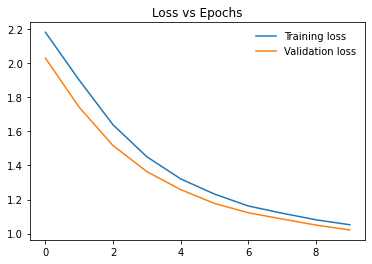

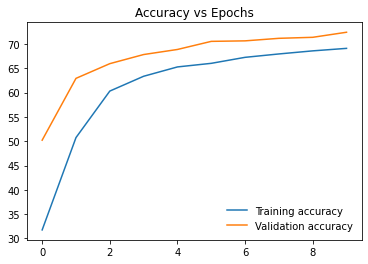

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

EPOCH = 10
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

main(trainloader=train_dataloader,
     validloader=valid_dataloader,
     model=model,
     criterion=criterion,
     optimizer=optimizer,
     device=device,
     epoch=EPOCH)

### **6. Teste do modelo treinado**

Com o modelo treinado, vamos verificar seu desempenho junto aos dados de teste.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predict(dataloader=test_dataloader, 
        model=model, 
        criterion=criterion, 
        device=device)

Test loss: 1.0519 -- Test accuracy: 68.96%


(1.0518845796585083, tensor(68.9583))

Exemplos de classificação

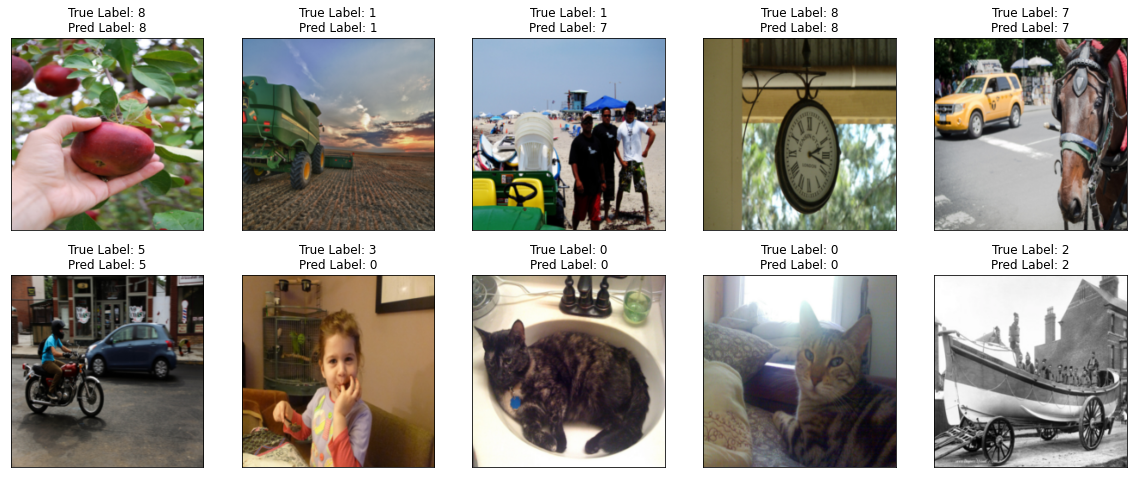

In [ ]:
# Batch de imagens normalizadas 
images, labels = next(iter(train_dataloader))  

# Passa o batch pelo modelo treinado
logits = model(images.to(device))

# Cálculo das probabilidades e da classe
probs = F.softmax(logits, dim=1)
top_prob, top_class = probs.topk(1, dim=1)

# Etapa de desnormalização das imagens - Necessário para visualização
mean = torch.tensor([0.485, 0.456, 0.406]).view((1, 3, 1, 1)) # shape foi modificado para permitir broadcasting
std = torch.tensor([0.229, 0.224, 0.225]).view((1, 3, 1, 1))  # shape foi modificado para permitir broadcasting
images = images * std + mean
images = np.transpose(images.numpy(), axes=(0, 2, 3, 1))

fig = plt.figure(figsize=(20, 8))
for i, image, true_label, pred_label in zip(range(10), images, labels, top_class):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f'True Label: {true_label}\nPred Label: {pred_label.cpu().item()}')
    plt.xticks([])
    plt.yticks([])